In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 2

In [3]:
f(3.0)

17.0

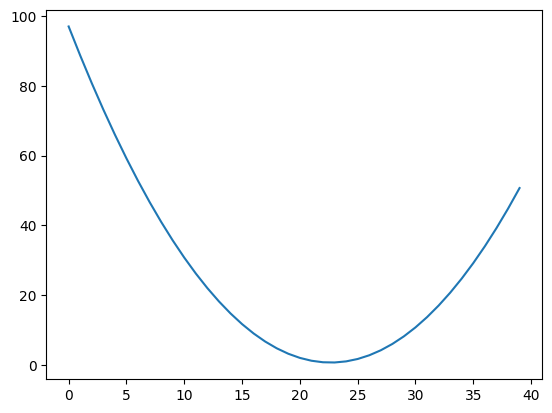

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(ys)

In [5]:
h = 0.00001 # small change
x = -3.0 # at some point x
(f(x+h) - f(x)) / h # slope

-21.999970000052823

In [6]:
h = 0.0001

# inputs
a = 2.0
b = -4.0
c = 6.0

# the expression
d = a*b + c

# differentiating d wrt to a, b and c
d1_a = (a+h)*b + c # bumping a slightly to study the effect on d

print('d', d)
print('d1_a', d1_a)
print(f'change: {d1_a - d}') # negative change means slop will be neg
print(f'slope: {(d1_a - d)/h}\n')

# wrt b
d1_b = a*(b+h) + c
print('d', d)
print('d1_b', d1_b)
print(f'change: {d1_b - d}')
print(f'slope: {(d1_b - d)/h}\n')

# wrt c
d1_c = a*b + (c+h)
print('d', d)
print('d1_c', d1_c)
print(f'change: {d1_c - d}')
print(f'slope: {(d1_c - d)/h}')

d -2.0
d1_a -2.000400000000001
change: -0.0004000000000008441
slope: -4.000000000008441

d -2.0
d1_b -1.9997999999999996
change: 0.00020000000000042206
slope: 2.0000000000042206

d -2.0
d1_c -1.9999000000000002
change: 9.999999999976694e-05
slope: 0.9999999999976694


In [62]:
# defining Value objects for storing values and their operations for backprop

# children is to know what is the heritage/parentage of a particular Value obj
# op is the previous operation which made that Value object
# label is identifier for a Value object just like variable name
# self.grad maintains the derivative of the final expression (loss fn in case of neural nets) wrt to that Value obj (weight object in nn)
# in _backward() we define how to grads will be defined at that stage / node i.e. local gradients ... note that in every def _backward() we are defining the grad 
    # calculated at that node and multiplying it with the grad of the out because of the chain rule 


class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = _children
        self._op = _op
        self.label = label
    
    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    def __radd__(self, other):
        return self + other

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out       
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        out._backward = _backward
        return out

    def __rmul__(self, other): # other * self
        return self * other
    
    def __truediv__(self, other): # self / other
        return self * other**-1
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only int / float vals allowed"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other*(self.data**(other-1)) * out.grad
        
        out._backward = _backward

        return out
    
    def __neg__(self): # -self
        return self * -1 

    def __sub__(self, other): # self - other
        return self + (-other)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward

        return out
    
    
    def exp(self):
        x = self.data
        e = math.exp(x)
        out = Value(e, (self,), 'exp')

        def _backward():
            self.grad += e * out.grad

        out._backward = _backward

        return out
    
    def backward(self):
        topo = []
        visited = set()

        def build_topo(value):
            if value not in visited:
                visited.add(value)
                for child in value._prev:
                    build_topo(child)
                topo.append(value)

        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [8]:
a = Value(5.0)
b = Value(6.0)
a - b

Value(data=-1.0)

In [9]:
d = a * b
d.label = 'd'
print(d)
print(d._prev)
print(d._op)

Value(data=30.0)
(Value(data=5.0), Value(data=6.0))
*


In [10]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d*f; L.label = 'L'
L

Value(data=-8.0)

In [11]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

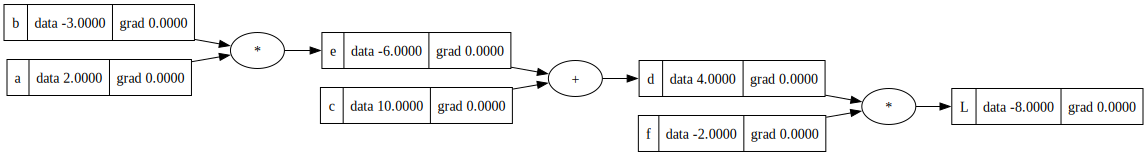

In [12]:
draw_dot(L)

In [13]:
#grad calculations manually:

# change in L wrt L is the same ... thus its grad will be 1

# L.grad = 1.0


# change in L wrt f:
# f.grad = dL / dF = (d*f)/dF = d = d.data


# change in L wrt d:
# d.grad = dL / dD = (d*f)/dD = f = f.data          ---- (i)


# change in L wrt e:
# e.grad = dL / dE = dL/dD * dD/dE = f (from i) * (c + e)/dE = f * 1 = f.data     --- (ii)


# change in L wrt c:
# c.grad = dL / dC = dL/dD * dD/dC = f (from i) * (c + e)/dC = f * 1 = f.data


# change in L wrt b:
# b.grad = dL / dB = dL/dD * dD/dE * dE/dB = f (from i) * 1 (from ii) * (a * b)/dB = f * 1 * a = f.data * a.data


# change in L wrt a:
# a.grad = dL / dA = dL/dD * dD/dE * dE/dA = f (from i) * 1 (from ii) * (a * b)/dA = f * 1 * b = f.data * b.data

In [14]:
L.grad = 1.0
f.grad = d.data
d.grad = f.data
e.grad = f.data
c.grad = f.data
b.grad = f.data * a.data
a.grad = e.grad * b.data

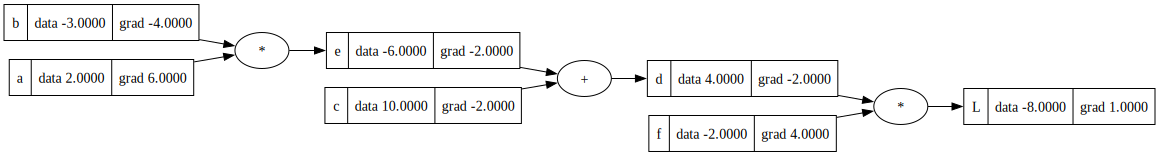

In [15]:
draw_dot(L)

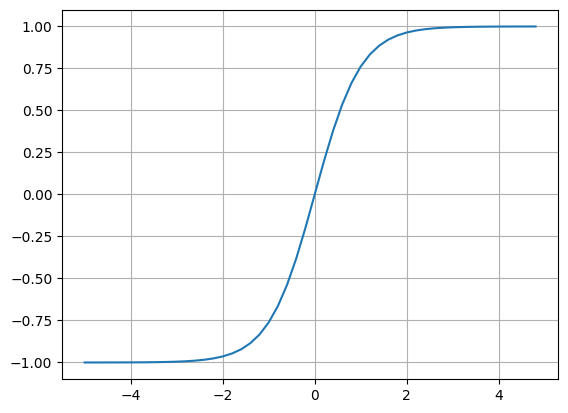

In [16]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5, 5, 0.2))); plt.grid()

In [17]:
# inputs x1, x2

x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2


w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813735870195432, label='b')

x1_w1 = x1*w1; x1_w1.label = 'x1_w1'
x2_w2 = x2*w2; x2_w2.label = 'x2_w2'

# forward pass: y = (w1_x1 + w2_x2 + ... + wN_xN) + b

xn_wn = x1_w1 + x2_w2; xn_wn.label = 'xn_wn'

y = xn_wn + b; y.label = 'y'

z = y.tanh(); z.label = 'z' # z is output

z.backward()

In [18]:
# z.backward()

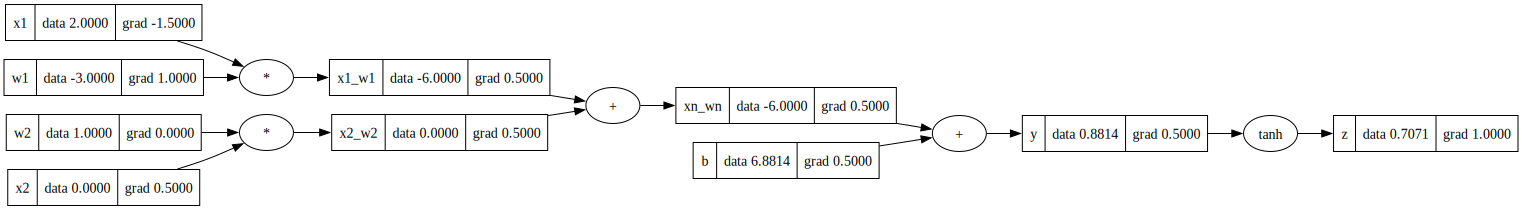

In [19]:
draw_dot(z)

In [20]:
z.grad = 1.0 # diff of z wrt z is 1
y.grad = 1 - z.data**2
xn_wn.grad = 0.5
b.grad = 0.5
x1_w1.grad = 0.5
x2_w2.grad = 0.5
x2.grad = x2_w2.grad * w2.data
w2.grad = x2_w2.grad * x2.data
x1.grad = x1_w1.grad * w1.data
w1.grad = x1_w1.grad * x1.data


# diff z wrt y

# dz/dy = d(tanh(y))/dy = 1 - tanh**2


# diff z wrt x2

# dz/dx2 = dz/dy * dy/dxn_wn * dxn_wn/dx2_w2 * dx2_w2/x2 = 0.5 * 1 * 1 * w2.data

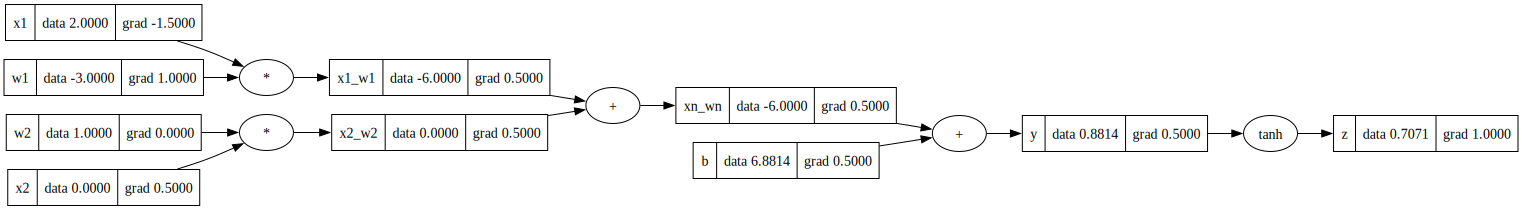

In [21]:
draw_dot(z)

### doing the backward pass using the _backaward() fn

In [26]:
# inputs x1, x2

x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813735870195432, label='b')

x1_w1 = x1*w1; x1_w1.label = 'x1_w1'
x2_w2 = x2*w2; x2_w2.label = 'x2_w2'

# forward pass: y = (w1_x1 + w2_x2 + ... + wN_xN) + b

xn_wn = x1_w1 + x2_w2; xn_wn.label = 'xn_wn'

y = xn_wn + b; y.label = 'y'

# --------

e = (2*y).exp()
z = (e-1) / (e+1)
z.label = 'z'

# -----

# z = y.tanh(); z.label = 'z' # z is output

In [27]:
z.backward()

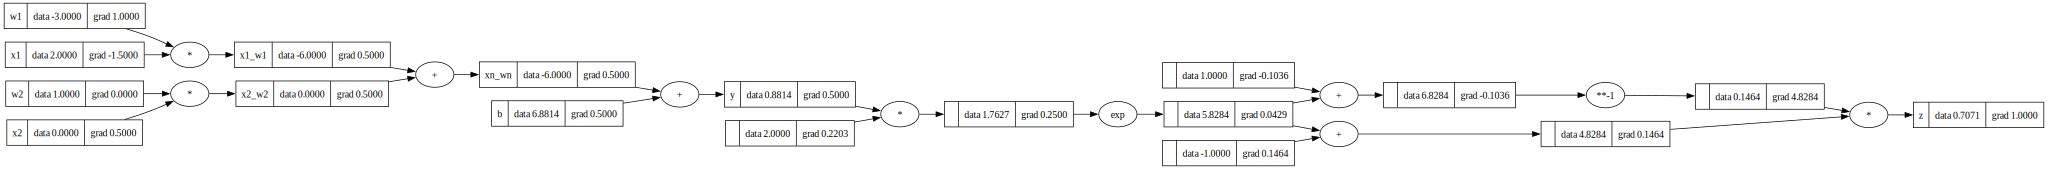

In [28]:
draw_dot(z)

In [25]:
import torch

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()


print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [77]:
import random

class Neuron:
    def __init__(self, num_inputs):
        # initialize random weights and biase for the neuron
        self.weights = [Value(random.uniform(-1,-1)) for _ in range(num_inputs)]
        self.biases = Value(random.uniform(-1,-1))

    def __call__(self, x):

        
        output = sum((wi*xi for wi, xi in zip(self.weights, x)), self.biases)
        output = output.tanh()
        return output
    
    def parameters(self):
        return self.weights + [self.biases]
    
class Layer:
    def __init__(self, num_inputs, num_outputs):
        self.neurons = [Neuron(num_inputs) for _ in range(num_outputs)]

    def __call__(self, x):
        output = [n(x) for n in self.neurons]
        return output[0] if len(output) == 1 else output
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        # params = []
        # for neuron in self.neurons:
        #     params.extend(neuron.parameters())
        # return params
    
class MLP:
    def __init__(self, num_inputs, num_outputs: list):
        size = [num_inputs] + num_outputs
        self.layers = [Layer(size[i], size[i+1]) for i in range(len(size)-1)] # as i+1 will go out of index

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x) # output of layer i is input of layer i+1
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [186]:
x = [2.0, 3.0]
model = MLP(3, [4,4,1])
model(x)

Value(data=-0.999905540010085)

In [187]:
x_train = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

y_train = [1.0, -1.0, -1.0, 1.0]

# ypred = [model(x) for x in x_train]
# ypred

In [188]:
def mse_loss(ypred, y_train):
    return (ypred - y_train)**2

In [322]:
for k in range(20):

    #forward
    ypreds = [model(x) for x in x_train]
    loss = sum(mse_loss(y_hat, y_actual) for y_hat, y_actual in zip(ypreds, y_train))

    # zero_grad
    for p in model.parameters():
        p.grad = 0.0

    loss.backward()

    # update
    for p in model.parameters():
        p.data += -0.1 * p.grad

    print(f"Epoch {k}, Loss: {loss.data}")

Epoch 0, Loss: 8.734331864176058e-05
Epoch 1, Loss: 8.729442169115049e-05
Epoch 2, Loss: 8.724558001504482e-05
Epoch 3, Loss: 8.719679351940522e-05
Epoch 4, Loss: 8.714806211042212e-05
Epoch 5, Loss: 8.709938569449e-05
Epoch 6, Loss: 8.705076417821001e-05
Epoch 7, Loss: 8.700219746840639e-05
Epoch 8, Loss: 8.695368547210682e-05
Epoch 9, Loss: 8.690522809655279e-05
Epoch 10, Loss: 8.6856825249196e-05
Epoch 11, Loss: 8.680847683769682e-05
Epoch 12, Loss: 8.676018276992234e-05
Epoch 13, Loss: 8.67119429539551e-05
Epoch 14, Loss: 8.666375729807071e-05
Epoch 15, Loss: 8.661562571076815e-05
Epoch 16, Loss: 8.656754810074518e-05
Epoch 17, Loss: 8.651952437689975e-05
Epoch 18, Loss: 8.647155444834419e-05
Epoch 19, Loss: 8.64236382243975e-05
